In [1]:
import sys

sys.path.insert(0, "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/mamba_segmentation")
sys.path.insert(0, "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/mamba_regression_alpha")
sys.path.insert(0, "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/mamba_regression_K")
sys.path.insert(0, "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/mamba_regression_K")
sys.path.insert(0, "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/segmentation_and_regression")

from train_fn import list_directory_tree_with_pathlib

In [2]:
import torch
from EmetMamba_alpha import EmetMamba as model_alpha
from EmetMamba_segmentation import EmetMamba as model_segmentation
from EmetMamba import EmetMamba as model_K
from EmetMamba_seg_and_regr import EmetMamba as model_seg_reg

In [3]:
# model_alpha = torch.load(
#     "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/mamba_regression_alpha/model_alpha_2_0p1_1e-4_8_8kexps"


In [4]:
model_segmentation = torch.load(
    "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/mamba_regression_K/model_segmentation_2_0p1_1e-4_4_8kexps"
)
# model_K = torch.load(
#     "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/mamba_regression_K/model_K_2_0p1_1e-4_4_8kexps"
# )

model_seg_reg = torch.load("/home/m.lavaud/ANDI_2_Challenge_EMetBrown/segmentation_and_regression/seg_and_reg_fewer_files")

/home/m.lavaud/miniconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/m.lavaud/miniconda3/envs/torch/lib/python3.12/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905971214/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
# model_alpha.eval()
model_segmentation.eval()
# model_K.eval()
model_seg_reg.eval()

EmetMamba(config=EmetConfig(d_model=3, n_layers=16, dt_rank=1, d_state=16, expand_factor=2, d_conv=4, dt_min=0.01, dt_max=0.1, dt_init='random', dt_scale=1.0, rms_norm_eps=1e-05, bias=False, conv_bias=True, inner_layernorms=False, pscan=True, use_cuda=True, bi_mamba_stacks=3, conv_stack=8, dropout=0.15))

In [25]:
data_path = "track_2/"
directory_files = list_directory_tree_with_pathlib(data_path)

In [29]:
import pandas as pd
import numpy as np


def apply_padding(data_df):
    # Define the finaT_l shape of the data and labels
    T_max = 200
    selected_ids = data_df["traj_idx"].unique()

    final_shape = (len(selected_ids), T_max, 3)

    # Initialize the final data and labels with zeros
    final_data = np.zeros(final_shape)

    # Iterate over the selected trajectory indices
    for n, id in enumerate(selected_ids):
        # Filter the data for the current trajectory index
        exp = data_df[data_df["traj_idx"] == id]

        # Extract the data and labels for the current trajectory
        data = exp[["frame", "x", "y"]].to_numpy()
        # print(exp["frame"])
        # data[:,0] = data[:,0] - data[0,0] + 1 #set first frame at 1
        # data[:,1] = data[:,1] - data[0,1]  ## Set x and y at 0
        # data[:,2] = data[:,2] - data[0,2] 
        # If the data is longer than T_max, truncate it
        if data.shape[0] > T_max:

            final_data[n, :, :] = data[:T_max, :]

        # Otherwise, pad the data to T_max
        else:
            # print((label.shape, T_max))
            final_data[n, : data.shape[0], :] = data
    # Return the padded data and labels
    return final_data

In [30]:
def read_dataset(file):
    df = pd.read_csv(file)
    nb_trajs = len(df["traj_idx"].unique())
    # dataset = np.zeros((np.ceil(nb_trajs/20).astype(int), 20, 200,3))

    df_padded = apply_padding(df)
    df_padded = df_padded[:, :, :]
    # if nb_trajs % 20 == 0:

    #     for i in range(dataset.shape[0]):
    #         dataset[i,:,:,:] = df_padded[i*20:(i+1)*20, :,:]

    # else :
    #     for i in range(dataset.shape[0] - 1):
    #         dataset[i,:,:,:] = df_padded[i*20:(i+1)*20, :,:]

    #     #On place i dans la dernière couche
    #     i+=1
    #     remaining_trajs = nb_trajs % 20
    #     dataset[i,:remaining_trajs,:,:] = df_padded[-remaining_trajs:, :, :]
    #     dataset[i,remaining_trajs:,:,:] = df_padded[:(20 - remaining_trajs), :, :]

    return torch.from_numpy(df_padded.astype(np.float32))

In [31]:
# results_alpha = {}
# results_K = {}
results_segmentation = {}

with torch.no_grad():
    for file in directory_files:
        data = read_dataset(file)
        data = data.to("cuda")
        # results_alpha[file] = model_alpha(data).squeeze()
        # results_K[file] = model_K(data).squeeze()
        results_segmentation[file] = torch.argmax(
            model_segmentation(data[:, :, 1:]).squeeze(), dim=-1
        )

        # segmentation, alpha, K = model_seg_reg(data)
        # results_alpha[file] = alpha.squeeze()
        # results_K[file] = K.squeeze()
        # results_segmentation[file] = torch.argmax(segmentation.squeeze(), dim=-1)

        

In [37]:
keys = list(results_alpha.keys())

In [38]:
import matplotlib.pyplot as plt

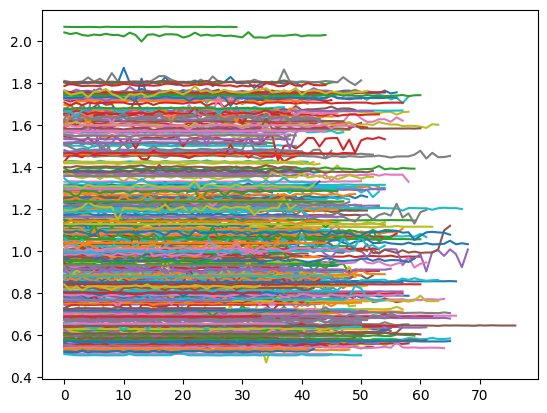

In [39]:
for i in keys:
    K = results_K[i].to("cpu")
    plt.plot(K[:, 0])

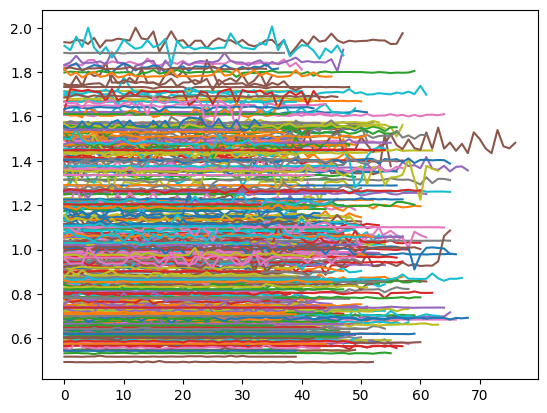

In [40]:
j = 0
for i in keys:
    K = results_K[i].to("cpu")
    plt.plot(K[:, 1])
    j += len(K[:, 1])

In [41]:
results_alpha

{PosixPath('../public_data_validation_v1/track_2/exp_10/trajs_fov_29.csv'): tensor([[1.1982, 1.1923],
         [1.1986, 1.1917],
         [1.1986, 1.1924],
         [1.1988, 1.1918],
         [1.1990, 1.1915],
         [1.1988, 1.1918],
         [1.1986, 1.1919],
         [1.1988, 1.1918],
         [1.1983, 1.1918],
         [1.1986, 1.1919],
         [1.1987, 1.1918],
         [1.1986, 1.1918],
         [1.1990, 1.1919],
         [1.1987, 1.1918],
         [1.1988, 1.1919],
         [1.1989, 1.1919],
         [1.1986, 1.1921],
         [1.1989, 1.1918],
         [1.1987, 1.1919],
         [1.1987, 1.1923],
         [1.1988, 1.1919],
         [1.1990, 1.1918],
         [1.1984, 1.1917],
         [1.1987, 1.1919],
         [1.1988, 1.1916],
         [1.1987, 1.1920],
         [1.1987, 1.1920],
         [1.1987, 1.1924],
         [1.1983, 1.1921],
         [1.1987, 1.1919],
         [1.1986, 1.1919],
         [1.1986, 1.1918],
         [1.1987, 1.1919],
         [1.1986, 1.1917],
       

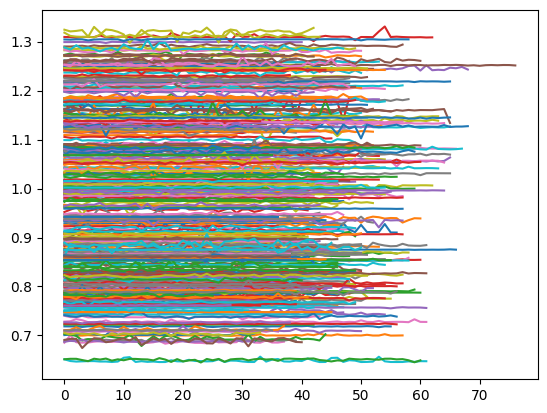

In [42]:
for i in keys:
    alpha = results_alpha[i].to("cpu")
    plt.plot(alpha[:, 0])

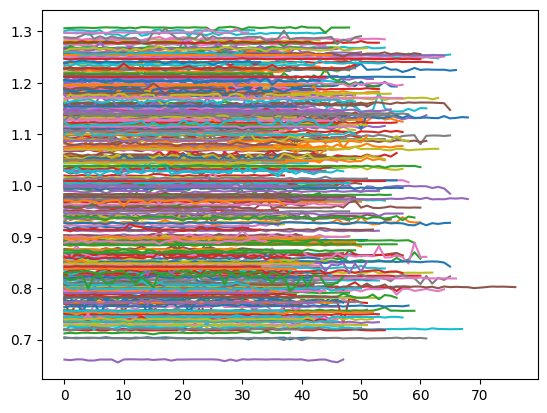

In [43]:
for i in keys:
    alpha = results_alpha[i].to("cpu")
    plt.plot(alpha[:, 1])

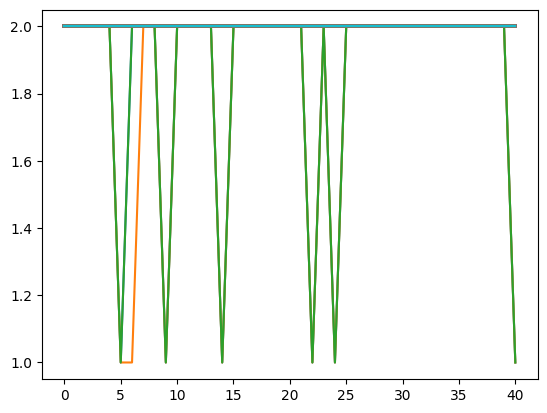

In [44]:
liste_unique = []
plt.figure()
for i in keys[:1]:

    segmentation = results_segmentation[i].to("cpu")
    plt.plot(segmentation)
    # a = len(np.unique(results_segmentation))
    # liste_unique.append(a)

# plt.plot(liste_unique)

In [45]:
results_segmentation[i].to("cpu").size()

torch.Size([41, 200])

In [46]:
file

PosixPath('../public_data_validation_v1/track_2/exp_2/trajs_fov_18.csv')

In [47]:
results_alpha[file]

tensor([[0.7502, 1.2600],
        [0.7507, 1.2595],
        [0.7513, 1.2579],
        [0.7532, 1.2559],
        [0.7540, 1.2550],
        [0.7523, 1.2562],
        [0.7542, 1.2554],
        [0.7523, 1.2562],
        [0.7530, 1.2571],
        [0.7512, 1.2574],
        [0.7530, 1.2552],
        [0.7505, 1.2592],
        [0.7522, 1.2564],
        [0.7511, 1.2577],
        [0.7506, 1.2589],
        [0.7508, 1.2579],
        [0.7516, 1.2576],
        [0.7509, 1.2583],
        [0.7513, 1.2580],
        [0.7512, 1.2574],
        [0.7508, 1.2584],
        [0.7500, 1.2594],
        [0.7504, 1.2595],
        [0.7514, 1.2575],
        [0.7509, 1.2584],
        [0.7505, 1.2587],
        [0.7529, 1.2554],
        [0.7520, 1.2564],
        [0.7532, 1.2551],
        [0.7512, 1.2580],
        [0.7510, 1.2592]], device='cuda:0')

In [48]:
df = pd.read_csv(file)

In [49]:
df

,traj_idx,frame,x,y
0,0.0,0.0,86.718445,146.393070
1,0.0,1.0,85.964687,145.933155
2,0.0,2.0,86.755880,146.217936
3,0.0,3.0,85.885044,145.486404
4,0.0,4.0,86.544656,146.468725
...,...,...,...,...
5541,30.0,195.0,58.513736,148.735369
5542,30.0,196.0,58.047409,149.668565
5543,30.0,197.0,59.068283,148.871918
5544,30.0,198.0,58.337647,148.232191


In [50]:
def generate_solution(file):
    
    df = pd.read_csv(file)

    total_sol = ""
    for id, group in df.groupby("traj_idx"):
        sol=""

        states = results_segmentation[file][int(id)].to("cpu") - 1
        alphas = results_alpha[file][int(id)].to("cpu")
        Ds = results_K[file][int(id)].to("cpu")
        unique_states = np.unique(states)
        
        if len(unique_states) == 1:
            
            if alphas[0] < 0.01:
                state = 1
            elif alphas[0] > 1.8:
                state = 3
            else:
                state = 2

            total_sol+= f"{int(id)},{Ds[0]},{alphas[0]},{state},{len(group["x"])}\n"
        else:

            state = [0,0]
            if alphas[0] < 0.01:
                state[0] = 1
            elif alphas[0] > 1.8:
                state[0] = 3
            else:
                state[0] = 2

            if alphas[1] < 0.01:
                state[1] = 1
            elif alphas[1] > 1.8:
                state[1] = 3
            else:
                state[1] = 2


            init_state = int(states[0])
            sol = f"{int(id)},{Ds[init_state]},{alphas[init_state]},{state[init_state]},"

            for i in range(len(group["frame"])):
                if int(states[i]) != init_state:
                    init_state = (init_state + 1) % 2
                    sol += f"{int(group["frame"].iloc[i])},{Ds[init_state]},{alphas[init_state]},{state[init_state]},"
            sol+=f"{len(group["x"])}\n"
            total_sol+=sol

    return total_sol

In [51]:
dict_solutions = {}
j=0
for i in keys:
    j=0
    dict_solutions[i] = generate_solution(i)

In [52]:
keys = list(dict_solutions.keys())

In [53]:
print(generate_solution(keys[5]))

0,1.7293564081192017,1.2186375856399536,2,45
1,1.7294576168060303,1.2191333770751953,2,91
2,1.7310166358947754,1.2185463905334473,2,200
3,1.7310059070587158,1.2186877727508545,2,3,0.9266760349273682,1.0668456554412842,2,139
4,1.7555263042449951,1.216005563735962,2,200
5,1.7299559116363525,1.2188268899917603,2,50
6,1.7337244749069214,1.21864652633667,2,3,0.9254371523857117,1.0667940378189087,2,200
7,1.762043833732605,1.2165334224700928,2,2,0.9105510115623474,1.0704154968261719,2,200
8,1.7269762754440308,1.2195740938186646,2,25
9,1.755712866783142,1.2169173955917358,2,147
10,1.726572871208191,1.2182170152664185,2,200
11,1.7341620922088623,1.2171087265014648,2,3,0.9244751930236816,1.0705941915512085,2,200
12,1.7307586669921875,1.2182884216308594,2,48
13,1.7293684482574463,1.2190589904785156,2,84
14,1.7609984874725342,1.2165192365646362,2,200
15,1.7344797849655151,1.2183092832565308,2,200
16,1.7504767179489136,1.2171661853790283,2,200
17,1.7362101078033447,1.2163124084472656,2,165
18,1.732

In [55]:
from copy import copy
from pathlib import Path

In [56]:
for i in keys:
    key = copy(i)
    file_name = i.parts[-1][6:-4] + ".txt"
    total_path = Path(*["solution", *i.parts[-3:-1],file_name])
    folder_path = Path(*total_path.parts[:-1])
    folder_path.mkdir(parents=True, exist_ok=True)

    with open(total_path, "w") as file:
        file.write(dict_solutions[key])


In [148]:
total_path

PosixPath('solution/track_2/exp_2/fov_18.txt')

In [134]:
dict_solutions[keys[0]]

'0, 0.0, 0.0, 1, 153\n1, 0.0, 0.0, 1, 26\n2, 0.0, 0.0, 1, 200\n3, 0.0, 0.0, 1, 200\n4, 0.0, 0.0, 1, 200\n5, 0.0, 0.0, 13.0, 0.0, 0.0, 1, 56\n6, 0.0, 0.0, 1179.0, 0.0, 0.0, 1, 180.0, 0.0, 0.0, 1, 22\n7, 0.0, 0.0, 1, 67\n8, 0.0, 0.0, 1, 200\n9, 0.0, 0.0, 185.0, 0.0, 0.0, 1, 52\n10, 0.0, 0.0, 1, 61\n11, 0.0, 0.0, 1, 111\n12, 0.0, 0.0, 1, 200\n13, 0.0, 0.0, 1, 200\n14, 0.0, 0.0, 13.0, 0.0, 0.0, 1, 200\n15, 0.0, 0.0, 1, 188\n16, 0.0, 0.0, 1, 200\n17, 0.0, 0.0, 1, 200\n18, 0.0, 0.0, 1, 200\n19, 0.0, 0.0, 1, 122\n20, 0.0, 0.0, 1, 43\n21, 0.0, 0.0, 1, 200\n22, 0.0, 0.0, 13.0, 0.0, 0.0, 1, 200\n23, 0.0, 0.0, 1, 136\n24, 0.0, 0.0, 13.0, 0.0, 0.0, 1, 200\n25, 0.0, 0.0, 1, 51\n26, 0.0, 0.0, 1, 144\n27, 0.0, 0.0, 1, 200\n28, 0.0, 0.0, 1, 200\n29, 0.0, 0.0, 1, 25\n30, 0.0, 0.0, 1, 24\n31, 0.0, 0.0, 1, 24\n32, 0.0, 0.0, 1, 200\n33, 0.0, 0.0, 1, 109\n34, 0.0, 0.0, 1, 34\n35, 0.0, 0.0, 1, 20\n36, 0.0, 0.0, 1, 23\n37, 0.0, 0.0, 1, 51\n38, 0.0, 0.0, 1, 200\n39, 0.0, 0.0, 1, 20\n40, 0.0, 0.0, 13.0, 0.0, 0

In [135]:
generate_solution(key)

'0, 0.027150867506861687, 0.027150867506861687, 2, 200\n1, 0.0268391165882349, 0.0268391165882349, 2, 200\n2, 0.026789465919137, 0.026789465919137, 2, 200\n3, 0.026789465919137, 0.026789465919137, 22.0, 0.02761705592274666, 0.02761705592274666, 2, 200\n4, 0.026841487735509872, 0.026841487735509872, 2, 200\n5, 0.026789465919137, 0.026789465919137, 22.0, 0.02761705592274666, 0.02761705592274666, 2, 200\n6, 0.026789465919137, 0.026789465919137, 2, 200\n7, 0.026789465919137, 0.026789465919137, 2, 200\n8, 0.026778608560562134, 0.026778608560562134, 2, 200\n9, 0.026789465919137, 0.026789465919137, 2, 200\n10, 0.026789465919137, 0.026789465919137, 21.0, 0.02761705592274666, 0.02761705592274666, 2, 200\n11, 0.026789465919137, 0.026789465919137, 2, 200\n12, 0.026789465919137, 0.026789465919137, 2, 200\n13, 0.026789465919137, 0.026789465919137, 2, 23\n14, 0.026854775846004486, 0.026854775846004486, 2, 200\n15, 0.026789465919137, 0.026789465919137, 2, 105\n16, 0.026789465919137, 0.026789465919137

In [131]:
pd.read_csv(key)

,traj_idx,frame,x,y
0,0.0,0.0,86.718445,146.393070
1,0.0,1.0,85.964687,145.933155
2,0.0,2.0,86.755880,146.217936
3,0.0,3.0,85.885044,145.486404
4,0.0,4.0,86.544656,146.468725
...,...,...,...,...
5541,30.0,195.0,58.513736,148.735369
5542,30.0,196.0,58.047409,149.668565
5543,30.0,197.0,59.068283,148.871918
5544,30.0,198.0,58.337647,148.232191
